In [5]:
import datetime
import glob
import itertools 
import matplotlib.pyplot as plt
import numpy as np
import os, sys
import pybedtools as pb
import pandas as pd
from scipy import stats

import seaborn as sns
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import subprocess
import time


sys.path.append("/dors/capra_lab/users/fongsl/tools/py_/")
import count_lines as cl
import fet
import plot_params as pp

sys.path.append("/dors/capra_lab/users/fongsl/tools/genome/")
import config_readwrite as crw
import chr_functions
import split_filename

pp.fonts()

('sans-serif', 'Arial', 18)

In [6]:
"""
Which most recent common ancestor (MRCA) do you want to evaluate?

if MRCA_HuRh is True - evaluate acceleration since MRCA of human/rhesus (more recent acceleration)
if MRCA_HuRh is False - evaluate acceleration since MRCA of human/chimp (more recent acceleration)

Below, MRCA_HuRh bool variable will change which acceleration estimate is used for enrichment, plotting. 
"""

MRCA_HuRh = True  

if MRCA_HuRh is True:
    
    BRANCH = "br-hg38.mod-hg38"   
    
else:  
    BRANCH = "br-hg38.mod-full"  

In [7]:
NAME = "/data/hodges_lab/ATAC-STARR_B-cells/bin_human-evolution/config"
config, configile_nameF = crw.read_config(NAME)

REGIONS = config["CIS_TRANS"]["regions"] # intersect w/extended summits
REGIONS_ANNOT = config["CIS_TRANS"]["regions_annotations"] # intersect w/extended summits
REGIONSxBINS = config["CIS_TRANS"]["regions_x_bins"]

RE = config["PHYLOP"]["results"]

BINS = config["BINS"]["bins"]
CONACC_BINS = config["PHYLOP"]["conacc_bins"]
CONACC_REGIONS_PATH = config["PHYLOP"]["regions_path"]

SELF_BINS = config["SELF"]["data"]

SHUF = config["SHUFFLES"]["shuf-all"]
SHUFxBINS = config["SHUFFLES"]["shuf_x_bins"] # write

PHYLOP_REGIONS=config["PHYLOP"][f"regions_no_self_{BRANCH}"]  # write

In [8]:
RE

'/data/hodges_lab/ATAC-STARR_B-cells/results/results_human-evolution/phylop'

# intersect regions, shuffles with bins
regions have to be intersected w/ bins in order to find bin with lowest (most negative) phylop value

In [9]:
def intersect_regions_x_bins(bins, regions, outfile):

    if os.path.exists(outfile) is False:
        b, r = pb.BedTool(bins), pb.BedTool(regions)
        r.intersect(b, wao=True, output=outfile)
    else:
        print("did this intersection already:", outfile)
    

In [10]:
pairs = [
        (REGIONS, REGIONSxBINS), 
        (SHUF, SHUFxBINS)
        ]

for i, j in pairs:
    intersect_regions_x_bins(BINS, i, j)

did this intersection already: /data/hodges_lab/ATAC-STARR_B-cells/results/results_human-evolution/regions/all_uniq_diffAct_regions2_x_bins.bed
did this intersection already: /data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/bkgd_sharedAcc_regions/shuffles/shuf-all_uniq_diffAct_regions2-all_x_bins.bed


# intersect w conacc

In [11]:
def merge_bins_x_conacc(region_x_bin, conacc):

    """
    return intersection of region_x_bin and phylop values
    
    input 
        bin_file - file with region coordinates x bin coordinates and annotations
        conacc - file with 50bp window phyloP measurements

    method
        1. open conacc file as pandas dataframe
        2. open region_x_bin file as pandas dataframe 
        3. rename columns in region_x_bin dataframe
        4. keep only bins where 50bp of the bin overlaps the region 
            (removes the edge effects where a region might not totally encompass a bin)
            
        5. merge region_x_bin dataframe with conacc dataframe on the bin annotation
        
        6. if shuffle, add shuffle_id, else keep region_id in shuf_id column
        
    output
        dataframe w/ region, bin, and conacc scores for each bin
    """
    
    #1
    conacc_df = pd.read_csv(conacc, sep = '\t')
    
    #2
    bin_df = pd.read_csv(region_x_bin, sep = '\t', header = None)
    
    #3 rename columns
    bin_cols = [
                "#chr", "start", "end", "region_id", 
                "#chr_bin", "start_bin", "end_bin", "bin", 
                "overlap"
               ]
    
    bin_df.columns = bin_cols
    
    #4 keep only bins that fully overlap the region. 
    bin_df = bin_df.loc[bin_df['overlap']==50]
    
    #5
    bin_df = pd.merge(bin_df, conacc_df).drop_duplicates()
    
    #6 
    if "shuf" in region_x_bin:
        bin_df["shuf_id"] = bin_df["#chr"] + ":"+ bin_df["start"].map(str)+ "-" + bin_df["end"].map(str)
    else:
        bin_df["shuf_id"] = bin_df["region_id"]
    
    return bin_df


In [12]:
REGxBINxCON= merge_bins_x_conacc(REGIONSxBINS, CONACC_BINS)
SHUFxBINxCON= merge_bins_x_conacc(SHUFxBINS, CONACC_BINS)

# REMOVE SELF 

In [13]:
def remove_self(self_bins, regxbinxcon):
    
    """
    return dataframe w/ self overlapping bins removed
    
    input - 
        self bins annotations (file) - TRUE = any bin where 50% of the bases overlap a self element
        regxbinxcon - (dataframe) regions mapped to bins mapped to phylop scores. 
        
    output 
        regxbinxcon with self elements removed
    
    method
        1. load self dataframe
        2. keep only the bin and self columns
        3. merge with regxbinxcon dataframe on bin annotation
        4. remove all the bins that overlap self

        
    """
    print(regxbinxcon.shape[0])
    #1
    self = pd.read_csv(self_bins, sep='\t')
    #2
    self = self[["bin", "self"]].drop_duplicates()
    #3
    df = pd.merge(regxbinxcon, self, on = "bin")
    #4
    noself = df.loc[df["self"]==False]
    
    print(noself.shape[0], round(noself.shape[0]/regxbinxcon.shape[0], 2))
    
    return noself

In [14]:
REGxBINxCON = remove_self(SELF_BINS, REGxBINxCON)
SHUFxBINxCON = remove_self(SELF_BINS, SHUFxBINxCON)

240462
166437 0.69
1383596
954265 0.69


# get min phylop scoring bin per region 

In [15]:
def get_min_phylop(df, branch, id_col):
    
    """
    return min phylop bin (50bp) in region 
    
    input 
        df - dataframe w/ region id and phyloP branch measurements
        branch (str) - column name for branch measured w phyloP
        id col - can be "shuf_id" or "region_id", 
            as region_id in shuffled dataframe corresponds to the original region the shuffle was made for.

    method
        1. drop duplicates
        2. groupby region_id, get min phyloP value for branch test
        3. rename the branch column as "phylop"
        4. add column for the phylop test
        
    output
        dataframe w/ two columns: region_id and min phyloP value
    """
    
    #1
    df = df[[id_col, branch, "region_id"]].drop_duplicates()
    
    #2
    min_phylop = df.groupby([id_col, "region_id"])[branch].min().reset_index()

    #3
    min_phylop = min_phylop.rename(columns = {branch:"phylop"})
    
    #4
    min_phylop["phylop_test"]=branch
    
    return min_phylop

In [16]:
REGION_ID = "shuf_id"

reg_min, shuf_min = get_min_phylop(REGxBINxCON, BRANCH, REGION_ID), get_min_phylop(SHUFxBINxCON, BRANCH, REGION_ID)

In [17]:
print(reg_min.shape, shuf_min.shape)

reg_min.describe(), shuf_min.describe()

(11801, 4) (105781, 4)


(             phylop
 count  11801.000000
 mean      -0.233990
 std        0.575328
 min       -7.579000
 25%       -0.509000
 50%       -0.174000
 75%        0.072000
 max        2.029000,
               phylop
 count  105781.000000
 mean       -0.103988
 std         0.620530
 min        -8.412000
 25%        -0.409000
 50%        -0.080000
 75%         0.203000
 max         2.739000)

# save the min phylop bin score for each region that does not overlap self. 

In [18]:
if os.path.exists(PHYLOP_REGIONS) is False:
    reg_min[["region_id", "phylop"]].drop_duplicates().to_csv(PHYLOP_REGIONS, sep = '\t', index=False)

# plot distribution of min phylop scores 

## MWU all active v. shuffles  

In [19]:
acc_stat, acc_p = stats.mannwhitneyu(reg_min["phylop"], shuf_min["phylop"])

acc_stat, acc_p 

(543015975.0, 2.1987869012460847e-119)

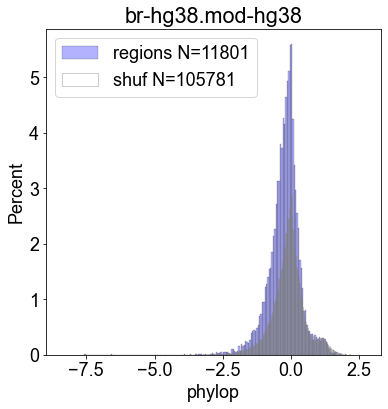

In [20]:
x="phylop"

fig,ax =plt.subplots(figsize=(6,6))
data = reg_min

sns.histplot(x=x, data=data, label = f"regions N={data.shape[0]}",  color = "blue", alpha = 0.3,stat="percent", common_norm=False)

data = shuf_min

sns.histplot(x=x, data=data, label = f"shuf N={data.shape[0]}", 
             color = "grey", alpha = 0.8, fill=False, stat="percent", common_norm=False)

plt.legend(loc="upper left")
plt.title(BRANCH)
#plt.text(0.5, -5, )
out = os.path.join(RE, f"{BRANCH}-all_regions_min_phylop_dist.pdf")
plt.savefig(out, bbox_inches="tight")
                   

# open regions annotation file 

In [21]:
regions = pd.read_csv(REGIONS_ANNOT, sep = '\t')
regions.head()

,#chr,start,end,region_id,conserved_active.regions,cis,trans,trans_only,cis_only,cis+trans,...,HH-active_MM-inactive_MH-inactive_cis,HH-active_MM-inactive_HM-inactive_trans,HH-active_MM-inactive_cis-only,HH-active_MM-inactive_trans-only,HH-active_MM-inactive_cis+trans,MM-active_HH-inactive_HM-inactive_cis,MM-active_HH-inactive_MH-inactive_trans,MM-active_HH-inactive_cis-only,MM-active_HH-inactive_trans-only,MM-active_HH-inactive_cis+trans
0,chr1,959034,959154,chr1:959034-959154,0.0,1.0,1.0,0,0,1,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,chr1,1002089,1002179,chr1:1002089-1002179,0.0,1.0,1.0,0,0,1,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,chr1,1064140,1064260,chr1:1064140-1064260,0.0,1.0,0.0,0,1,0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,chr1,1214948,1215208,chr1:1214948-1215208,0.0,1.0,1.0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
4,chr1,1215328,1215508,chr1:1215328-1215508,0.0,1.0,0.0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [22]:
# cols to test for enrichment v. shuffle

active_categories = [
            'conserved_active.regions',

            'cis_only',
            'trans_only',
            'cis+trans',

            'HH-active_MM-inactive_cis-only',
            'HH-active_MM-inactive_trans-only',
            'HH-active_MM-inactive_cis+trans',

            'MM-active_HH-inactive_cis-only',
            'MM-active_HH-inactive_trans-only',
            'MM-active_HH-inactive_cis+trans'
            ]

# nominal phylop cutoffs

cutoffs = [-2, -1.3, -1, -0.5, 0]

# combine active_categories w/ cutoffs

categories_x_cutoffs = itertools.product(active_categories, cutoffs)

In [23]:
def get_active_category_region_ids(region_annot, active_category):
    """
    return set of region_ids overlapping the activity category
    
    input
        region_annot (pandas dataframe) - dataframe with region_id and activity category as column
        activity_category (str) - name of column w/ activity annotation
    
    output
        set list of region_ids that overlap that activity category
    
    """
    
    ids = list(set(region_annot.loc[region_annot[active_category]==1, "region_id"]))

    return ids

In [24]:
# get cis-only elements
cis_only = get_active_category_region_ids(regions, "cis_only")

# find their accelerated values + matched cis-only shuffled accelerated values
cmin, shuf_cmin = reg_min.loc[reg_min["region_id"].isin(cis_only)], shuf_min.loc[shuf_min["region_id"].isin(cis_only)], 

cmin.head()

,shuf_id,region_id,phylop,phylop_test
4,chr10:100267250-100267690,chr10:100267250-100267690,0.047,br-hg38.mod-hg38
5,chr10:100267780-100267910,chr10:100267780-100267910,-0.695,br-hg38.mod-hg38
18,chr10:101587898-101588108,chr10:101587898-101588108,-0.461,br-hg38.mod-hg38
24,chr10:101818413-101818523,chr10:101818413-101818523,0.302,br-hg38.mod-hg38
31,chr10:102151839-102151969,chr10:102151839-102151969,-0.191,br-hg38.mod-hg38


# NLRP1 accelerated region 

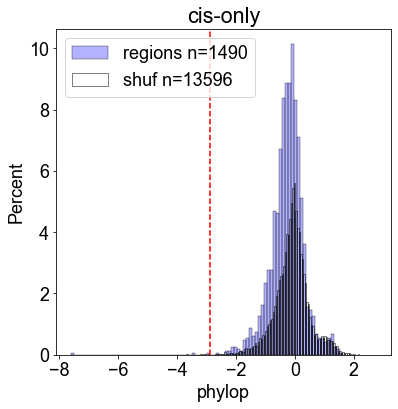

In [25]:
x="phylop"

fig,ax =plt.subplots(figsize=(6,6))
data = cmin

sns.histplot(x=x, data=data, label = f"regions n={data.shape[0]}",  color = "blue", alpha = 0.3,stat="percent", common_norm=False)

data = shuf_cmin

sns.histplot(x=x, data=data, label = f"shuf n={data.shape[0]}", 
             color = "k", alpha = 1, fill=False, stat="percent", common_norm=False)


plt.axvline(-2.89, ls = "--", color ="r")
plt.legend(loc="upper left")
#plt.title(BRANCH)
plt.title("cis-only")

out = os.path.join(RE, f"{BRANCH}-regions_min_phylop_dist_cis-only.pdf")
plt.savefig(out, bbox_inches="tight")


## rank elements by acceleration score

In [26]:
reg_min["phylop_rank"] = reg_min["phylop"].rank()
cmin["phylop_rank"] = cmin["phylop"].rank()
cmin["phylop_rank_pct"] = cmin["phylop"].rank(pct=True)
cmin["phylop_rank_pct"] = 1-cmin["phylop_rank_pct"]

/home/fongsl/.conda/envs/sfenv/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/fongsl/.conda/envs/sfenv/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/fongsl/.conda/envs/sfenv/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

In [27]:
print(cmin.shape)

cmin.sort_values(by ="phylop").head(25)

(1490, 6)


,shuf_id,region_id,phylop,phylop_test,phylop_rank,phylop_rank_pct
6527,chr2:120177237-120177327,chr2:120177237-120177327,-7.579,br-hg38.mod-hg38,1.0,0.999329
547,chr10:97412859-97413209,chr10:97412859-97413209,-3.476,br-hg38.mod-hg38,2.0,0.998658
5677,chr1:70410835-70411095,chr1:70410835-70411095,-2.901,br-hg38.mod-hg38,3.0,0.997987
11178,chr8:78805017-78805227,chr8:78805017-78805227,-2.605,br-hg38.mod-hg38,4.0,0.997315
5471,chr1:41667150-41667430,chr1:41667150-41667430,-2.333,br-hg38.mod-hg38,5.0,0.996644
9880,chr6:2858593-2858693,chr6:2858593-2858693,-2.300,br-hg38.mod-hg38,6.0,0.995973
4684,chr1:165631980-165632190,chr1:165631980-165632190,-2.241,br-hg38.mod-hg38,7.0,0.995302
892,chr11:47268738-47269138,chr11:47268738-47269138,-2.187,br-hg38.mod-hg38,8.0,0.994631
9304,chr5:181191716-181191876,chr5:181191716-181191876,-2.164,br-hg38.mod-hg38,9.0,0.993960
10383,chr7:138000178-138000448,chr7:138000178-138000448,-2.139,br-hg38.mod-hg38,10.0,0.993289


# chr17 acceleration

In [28]:
reg_min.loc[reg_min["region_id"].str.contains("chr17")].sort_values(by = "phylop")

,shuf_id,region_id,phylop,phylop_test,phylop_rank
3763,chr17:30477241-30477721,chr17:30477241-30477721,-3.914,br-hg38.mod-hg38,3.0
3747,chr17:29294315-29294505,chr17:29294315-29294505,-3.285,br-hg38.mod-hg38,10.0
3960,chr17:67366380-67366680,chr17:67366380-67366680,-2.740,br-hg38.mod-hg38,22.0
3998,chr17:7252371-7252611,chr17:7252371-7252611,-2.415,br-hg38.mod-hg38,52.0
3720,chr17:28335288-28335818,chr17:28335288-28335818,-2.304,br-hg38.mod-hg38,66.0
...,...,...,...,...,...
4143,chr17:80545328-80545428,chr17:80545328-80545428,1.191,br-hg38.mod-hg38,11663.0
4075,chr17:7632621-7632711,chr17:7632621-7632711,1.205,br-hg38.mod-hg38,11673.5
3934,chr17:58339759-58339859,chr17:58339759-58339859,1.226,br-hg38.mod-hg38,11685.5
3903,chr17:57603842-57603932,chr17:57603842-57603932,1.265,br-hg38.mod-hg38,11711.0


# fraction overlap expectation 

In [29]:
def calculateEmpiricalP(obs, exp_sum_list):
    """
    return two lists
        (1) info - vector w/  
                n_obs, 
                median_exp, 
                std, 
                fold-change  # calculated from the median of expected shuffle 
                p_val
                
        (2) fold_changes- vector expected fold changes (to calculate confidence interval)
        
    input
        observed overlap count (int)
        list of expected overlap counts (list of ints)
    
    method
        1. get median of expected overlap counts
        2. get standard deviation of expected overlap counts
        3. center expected overlap counts at median
        4. Sum the number of centered expected counts greater than observed centered count
            This is two tailed because it evaluates both sides of the distribution (w/ abs value). 
        5. calculate fold change as observed/ median expected w/ pseudo count
        6. calculate fold change of each "obs"/ expected w/ pseudo count
        7. calculate the p-value as count of equal or more extreme values than observed value
        8. return list of empirical info + fold changes
        
        
    
    """
    #1 median of exp distribution
    mu = np.median(exp_sum_list)  
    
    #2 std
    sigma = np.std(exp_sum_list)  
    
    #3 center at median of distribution 
    dist_from_mu = [exp - mu for exp in exp_sum_list]  
    
    #4 # count values >= centered obs
    p_sum = sum(1 for exp_dist in dist_from_mu if abs(exp_dist) >= abs(obs - mu)) 

    #5 fold change obs from median expected w pseudo count
    fold_change = (obs + 1.0) / (mu + 1.0) 
    
    #6 fold change obs from /each exp w pseudo count
    fold_changes = list((obs + 1.0) / (m + 1.0) for m in exp_sum_list) 
    
    #7 probability of observing obs-like value 
    # equal or more extreme in expected distribution
    p_val = (p_sum + 1.0) / (len(exp_sum_list) + 1.0)  
    
    #8
    info = [
            obs, 
            mu, 
            sigma, 
            fold_change, 
            p_val, 
            str(datetime.datetime.now())
            ]
    
    #return info, fold_changes
    return p_val

In [30]:
def compute_obs_exp_frac(region_annot, reg_min_df, shuf_min_df, active_category, cutoff):
    """
    return enrichment of activity col for min phylop versus 10x matched background
    
    input
        region_annot (dataframe) - differential activity annotations for each region
        reg_min_df (dataframe) - regions dataframe with shuf_id (copy of region_id), region_id, and min_phylop columns
        shuf_min_df (dataframe) - matched shuffles dataframe with shuf_id, region_id, and min_phylop columns
        
        active_category (str) - activity column to measure enrichment of phylop scores 
        cutoff (int) - nominal phylop cutoff
    
    output
        dataframe with fisher's exact test for enrichment of regions w/ phylop scores lower than cutoff 
            versus length-matched shuffles in the shared accessible, inactive background. 
        
    method
        1. get region_ids to test w/ function get_active_category_region_ids
        2. get subset of dataframes overlapping these region_ids
        3. count number of elements with value more extreme than phylop cutoff, less than or equal to cutoff
            for regions, for matched shuffles
        4. bootstrap overlap
        5. quantify FET enrichment
        6. add columns to identify test
        7. return FET dataframe
    """
   
    #1
    active_ids = get_active_category_region_ids(region_annot, active_category)
    
    #2
    act_regions = reg_min_df.loc[(reg_min_df["region_id"].isin(active_ids))]
    act_shufs = shuf_min_df.loc[(shuf_min_df["region_id"].isin(active_ids))]
    
    #3
    a,b = act_regions.loc[act_regions["phylop"]<cutoff].shape[0], act_regions.loc[act_regions["phylop"]>=cutoff].shape[0]
    #c,d = act_shufs.loc[act_shufs["phylop"]<cutoff].shape[0], act_shufs.loc[act_shufs["phylop"]>=cutoff].shape[0]
    
    obs = a/(a+b)
    exp_list=[]

    # com
    for i in range(10000):
        # sample random shuffled sets, size of active_category elements, with replacement
        random_shuf_set = act_shufs.sample(n=len(active_ids), replace=True)
        
        # get N elements < acceleration cutoff, N >= cutoff. 
        c,d = random_shuf_set.loc[random_shuf_set["phylop"]<cutoff].shape[0], random_shuf_set.loc[random_shuf_set["phylop"]>=cutoff].shape[0]
        
        # compute fraction accelerated
        random_exp = c/(c+d)
        
        # append to list
        exp_list.append(random_exp)
        
    return obs, exp_list

In [31]:
def subtractList(a_list, b_list):
    
    """
    compute difference between two lists
    return list of a_list - b_list
    """
    dif_list = []
    for ia, ib in zip(a_list,b_list):
        dif_list.append(ia-ib)
        
    return dif_list

In [32]:
# cols to test for enrichment v. shuffle

active_categories = [


            ('cis_only',
            'trans_only'),

            ('HH-active_MM-inactive_cis-only',
            'HH-active_MM-inactive_trans-only'),
            ]

# nominal phylop cutoffs

cutoffs = [-2, -1.3, -1, -0.5, 0]

# combine active_categories w/ cutoffs

frac_categories_x_cutoffs = itertools.product(active_categories, cutoffs)

results = {}
for active_category, cutoff in frac_categories_x_cutoffs:
    cis, trans = active_category
    
    cis_obs, cis_exp = compute_obs_exp_frac(regions, reg_min, shuf_min, cis, cutoff)
    trans_obs, trans_exp = compute_obs_exp_frac(regions, reg_min, shuf_min, trans, cutoff)
    
    dif_obs = cis_obs - trans_obs 
    dif_exp = subtractList(cis_exp, trans_exp)
    
    key = "-".join(active_category) + f"-{cutoff}"
    results[key] = (active_category, cutoff, dif_obs, dif_exp)
    

## plot empirical distributions 

### function

In [33]:
def plotEmpiricalDist(exp_dist, obs, title, xlabel, re, sample_name, p):
    fig, ax = plt.subplots(figsize=(4,4))
    sns.histplot(exp_dist)
    ax.set(
          title=title,
          xlabel=xlabel,
    )
    ax.axvline(obs, c = "k")
    ax.text(obs, 10, f"emp. p={p}")
    
    out = os.path.join(RE, sample_name + f"empdist.frac.pdf" )
    plt.savefig(out, bbox_inches="tight")
    plt.show()

### iterate through results

In [38]:
len(value)

4

('cis_only', 'trans_only')


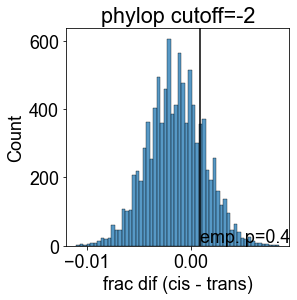

('cis_only', 'trans_only')


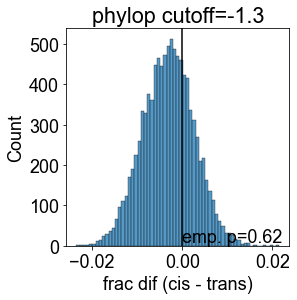

('cis_only', 'trans_only')


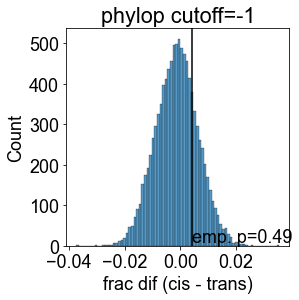

('cis_only', 'trans_only')


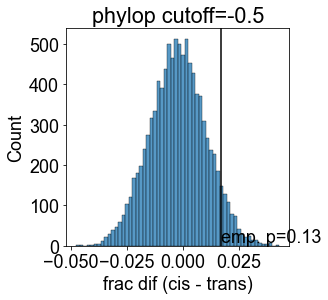

('cis_only', 'trans_only')


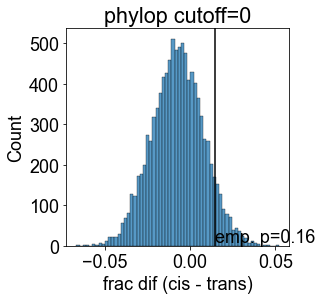

('HH-active_MM-inactive_cis-only', 'HH-active_MM-inactive_trans-only')
HH


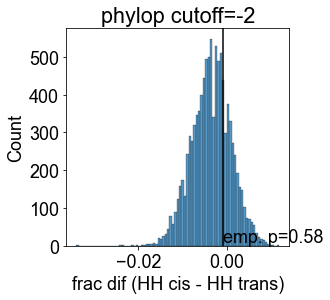

('HH-active_MM-inactive_cis-only', 'HH-active_MM-inactive_trans-only')
HH


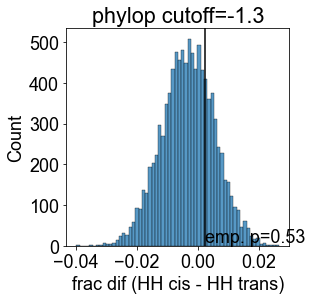

('HH-active_MM-inactive_cis-only', 'HH-active_MM-inactive_trans-only')
HH


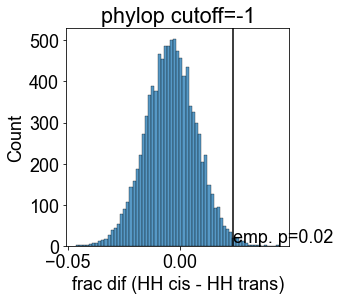

('HH-active_MM-inactive_cis-only', 'HH-active_MM-inactive_trans-only')
HH


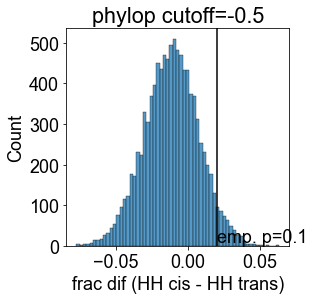

('HH-active_MM-inactive_cis-only', 'HH-active_MM-inactive_trans-only')
HH


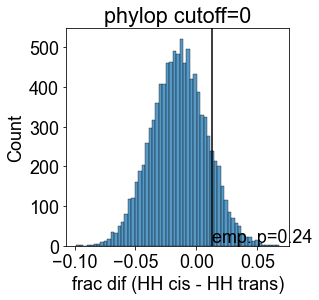

In [55]:
for value in results.values():
    active_category, cutoff, dif_obs, dif_exp = value
    p = calculateEmpiricalP(dif_obs, dif_exp)
    
    print(active_category)
   
    title=f"phylop cutoff={cutoff}"
    if active_category[0] =="HH-active_MM-inactive_cis-only":
        print("HH")
        xlabel=f"frac dif (HH cis - HH trans)"
    else:
        xlabel=f"frac dif (cis - trans)"
    sample_name = f"{active_category}.{cutoff}"
    plotEmpiricalDist(dif_exp, dif_obs, title, xlabel, RE, sample_name, round(p, 2))

In [52]:
active_category[0]

'HH-active_MM-inactive_cis-only'

# test conserved activity column for OR enrichment 

In [27]:
def compute_OR_v_shuf(region_annot, reg_min_df, shuf_min_df, active_category, cutoff):
    """
    return enrichment of activity col for min phylop versus 10x matched background
    
    input
        region_annot (dataframe) - differential activity annotations for each region
        reg_min_df (dataframe) - regions dataframe with shuf_id (copy of region_id), region_id, and min_phylop columns
        shuf_min_df (dataframe) - matched shuffles dataframe with shuf_id, region_id, and min_phylop columns
        
        active_category (str) - activity column to measure enrichment of phylop scores 
        cutoff (int) - nominal phylop cutoff
    
    output
        dataframe with fisher's exact test for enrichment of regions w/ phylop scores lower than cutoff 
            versus length-matched shuffles in the shared accessible, inactive background. 
        
    method
        1. get region_ids to test w/ function get_active_category_region_ids
        2. get subset of dataframes overlapping these region_ids
        3. count number of elements with value more extreme than phylop cutoff, less than or equal to cutoff
            for regions, for matched shuffles
        4. name comparison
        5. quantify FET enrichment
        6. add columns to identify test
        7. return FET dataframe
    """
   
    #1
    active_ids = get_active_category_region_ids(region_annot, active_category)
    
    #2
    act_regions = reg_min_df.loc[(reg_min_df["region_id"].isin(active_ids))]
    act_shufs = shuf_min_df.loc[(shuf_min_df["region_id"].isin(active_ids))]
    
    #3
    a,b = act_regions.loc[act_regions["phylop"]<cutoff].shape[0], act_regions.loc[act_regions["phylop"]>=cutoff].shape[0]
    c,d = act_shufs.loc[act_shufs["phylop"]<cutoff].shape[0], act_shufs.loc[act_shufs["phylop"]>=cutoff].shape[0]
    
    #4
    comparison = f"{active_category}-region_v_shuf_phylop{cutoff}"
    
    #5
    OR = fet.get_2x2(a,b,c,d, comparison)
    
    #6
    OR["bkgd"] = "matched_shufffle"
    
    OR["phylop_cutoff"] = cutoff
    
    OR["activity"] = active_category
    
    OR["-log10p"] = np.log10(OR["P"])*-1
    
    OR["frac"]=OR["a"]/(OR["a"]+OR["b"])
    OR["frac"] = OR["frac"].round(2)
    
    OR["astrisks"] = None
    OR.loc[OR["P"]<0.05, "astrisks"] = "*"
    
    OR = OR.replace(-np.inf, -1)
    
    #7
    return OR

In [28]:
results_ = {}

for active_category, cutoff in categories_x_cutoffs:
    
    key = f"{active_category}{cutoff}"
    or_ = compute_OR_v_shuf(regions, reg_min, shuf_min, active_category, cutoff)
    results_[key]=or_

[[36, 2079], [237, 19261]]
conserved_active.regions-region_v_shuf_phylop-2 [[36, 2079], [237, 19261]] 1.4072734579063693 0.06432515703780634
[[152, 1963], [1030, 18468]]
conserved_active.regions-region_v_shuf_phylop-1.3 [[152, 1963], [1030, 18468]] 1.3883722655535167 0.0004142400166169466
[[272, 1843], [1835, 17663]]
conserved_active.regions-region_v_shuf_phylop-1 [[272, 1843], [1835, 17663]] 1.4206005195296734 9.120193741690054e-07
[[779, 1336], [5254, 14244]]
conserved_active.regions-region_v_shuf_phylop-0.5 [[779, 1336], [5254, 14244]] 1.5807853269479313 5.661849507480272e-21
[[1699, 416], [13195, 6303]]
conserved_active.regions-region_v_shuf_phylop0 [[1699, 416], [13195, 6303]] 1.950913261142041 3.061119839290865e-35
[[16, 1474], [96, 13500]]
cis_only-region_v_shuf_phylop-2 [[16, 1474], [96, 13500]] 1.5264586160108549 0.11336126175384534
[[64, 1426], [451, 13145]]
cis_only-region_v_shuf_phylop-1.3 [[64, 1426], [451, 13145]] 1.308110696815243 0.05078440289883674
[[126, 1364], [858, 

In [41]:
# FDR correction

results = fet.fdr_correction(results_)

results

In [44]:
#results = pd.concat(results_.values())
active_comps = [
                ("all", [
                'cis_only',    
                'trans_only',
                'cis+trans',
                'conserved_active.regions',
                ]),
     ("Main", [
                'cis_only',    
                'trans_only',
                'cis+trans',
                
                ]),

                ("HH-active", [
                'HH-active_MM-inactive_cis-only',
                'HH-active_MM-inactive_trans-only',
                'HH-active_MM-inactive_cis+trans'
                ]),

                ("MM-active",[
                'MM-active_HH-inactive_cis-only',
                'MM-active_HH-inactive_trans-only',
                'MM-active_HH-inactive_cis+trans'])
                ]



# plot OR results for regions x shuffles 

In [45]:
def annotate_bar(graph, annot, height):
    for p, a in zip(graph.patches, annot):

        graph.annotate(a, 
                            (p.get_x() + p.get_width() / 2.0, height),
                            #p.get_height()-1), 
                            ha = 'center', 
                            va = 'center', 
                            xytext = (0, 5),
                            textcoords = 'offset points')

In [46]:
def reindex_in_comp_order(data, comp):
    d = data.set_index("activity")
    d = d.loc[comp].reset_index()
    return d

In [47]:
def plot_or(active_comps, plot_results, bkgd, branch):
    
    """
    plot odds ratio
    
    active_comps (list) of tuples - groups of activity categories to compare
    """
    for name, comp in active_comps:

        y="OR_log2"
        x="activity"
        size="frac"
        ci_upper, ci_lower= "ci_upper_log2", "ci_lower_log2"

        fig, ax_ = plt.subplots(ncols = 3, nrows =2, figsize =(22,14))
        row = 0

        if "HH" in name or "MM" in name:
            palette=sns.color_palette()[1:]
        else:
            palette = sns.color_palette()

        for i, cutoff in enumerate(cutoffs):

            if i>2:
                row =1
                col = i-3
            else:
                col = i
            ax = ax_[row][col]

            test = plot_results.loc[(plot_results["activity"].isin(comp))
                              &(plot_results["phylop_cutoff"]==cutoff)]
            data=reindex_in_comp_order(test, comp)


            # get difference between y and upper/lower CI for plotting. 
            l = np.array(data[y]-data[ci_lower])
            u = np.array(data[ci_upper]- data[y])

            yerr = [l, u]

            sns.barplot(
                x=x, y=y, data=data,
                order = comp,
                palette=palette,
                linewidth=2.5, 
                edgecolor=".2",
                **{"yerr":yerr},
                ax=ax

                )
            ax.set(xlabel =branch,
                   ylabel = "log2OR",
                   title=f"{name} v {bkgd}, phylop={cutoff}",
                   ylim =(-1, (data[ci_upper].max()+data[ci_upper].max()*0.5))
                  )
            #if data[ci_lower].min()>-0.2:
             #   ax.set_ylim(-1, (data[ci_upper].max()+data[ci_upper].max()*0.5))

            ax.axhline(0, color="k")

            if row ==0:
                ax.set_xticklabels("")
            else:
                ax.set_xticklabels(ax.get_xticklabels(), rotation =60, horizontalalignment="right")
            
            if col>0:
                ax.set_ylabel("")
            
            annotate_bar(ax, data["astrisks"], (data[ci_upper].max()-data[ci_upper].max()*0.05))
            annotate_bar(ax, data["a"], 0.05)
            annotate_bar(ax, data["frac"].round(2),-0.25)
            #annotate_bar(ax, data["OR"].round(2), (data[ci_upper].max()-data[ci_upper].max()*0.2))
        out = os.path.join(RE, f"{branch}-{name}_v_{bkgd}_phylop_min.pdf")

        plt.savefig(out, bbox_inches = "tight")
                       

## plot results 

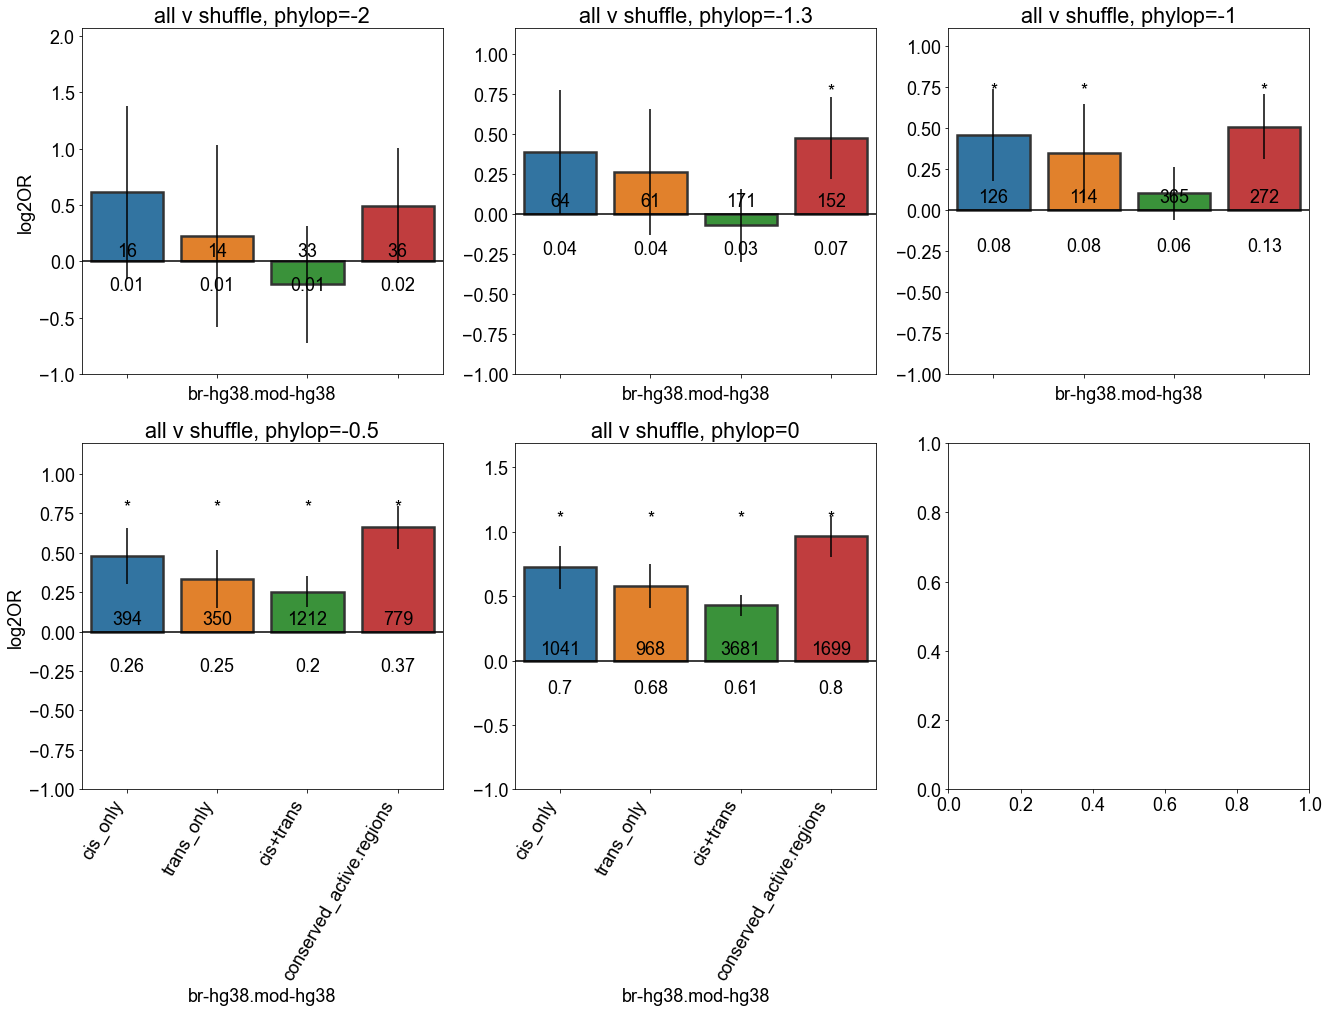

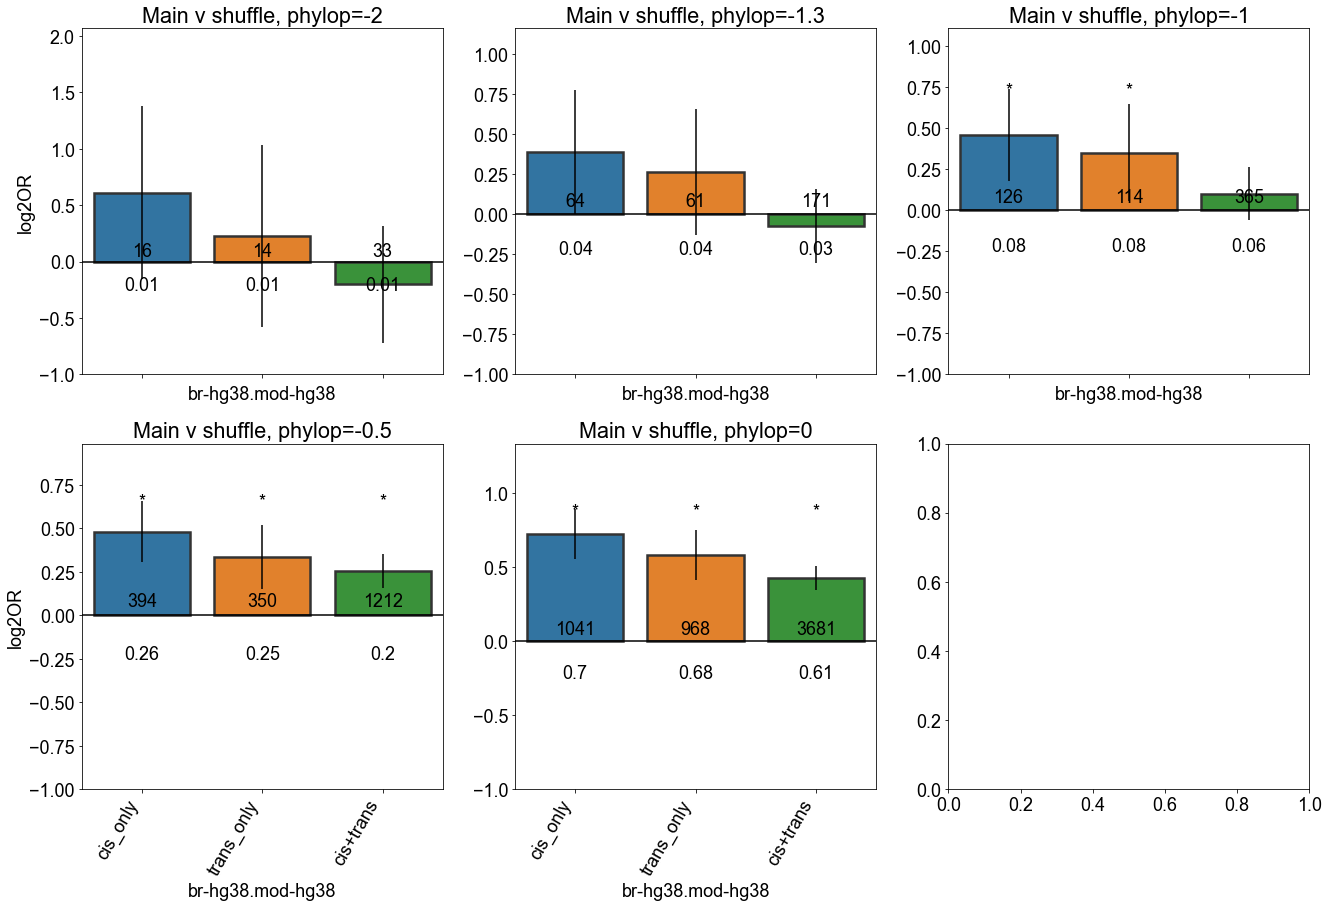

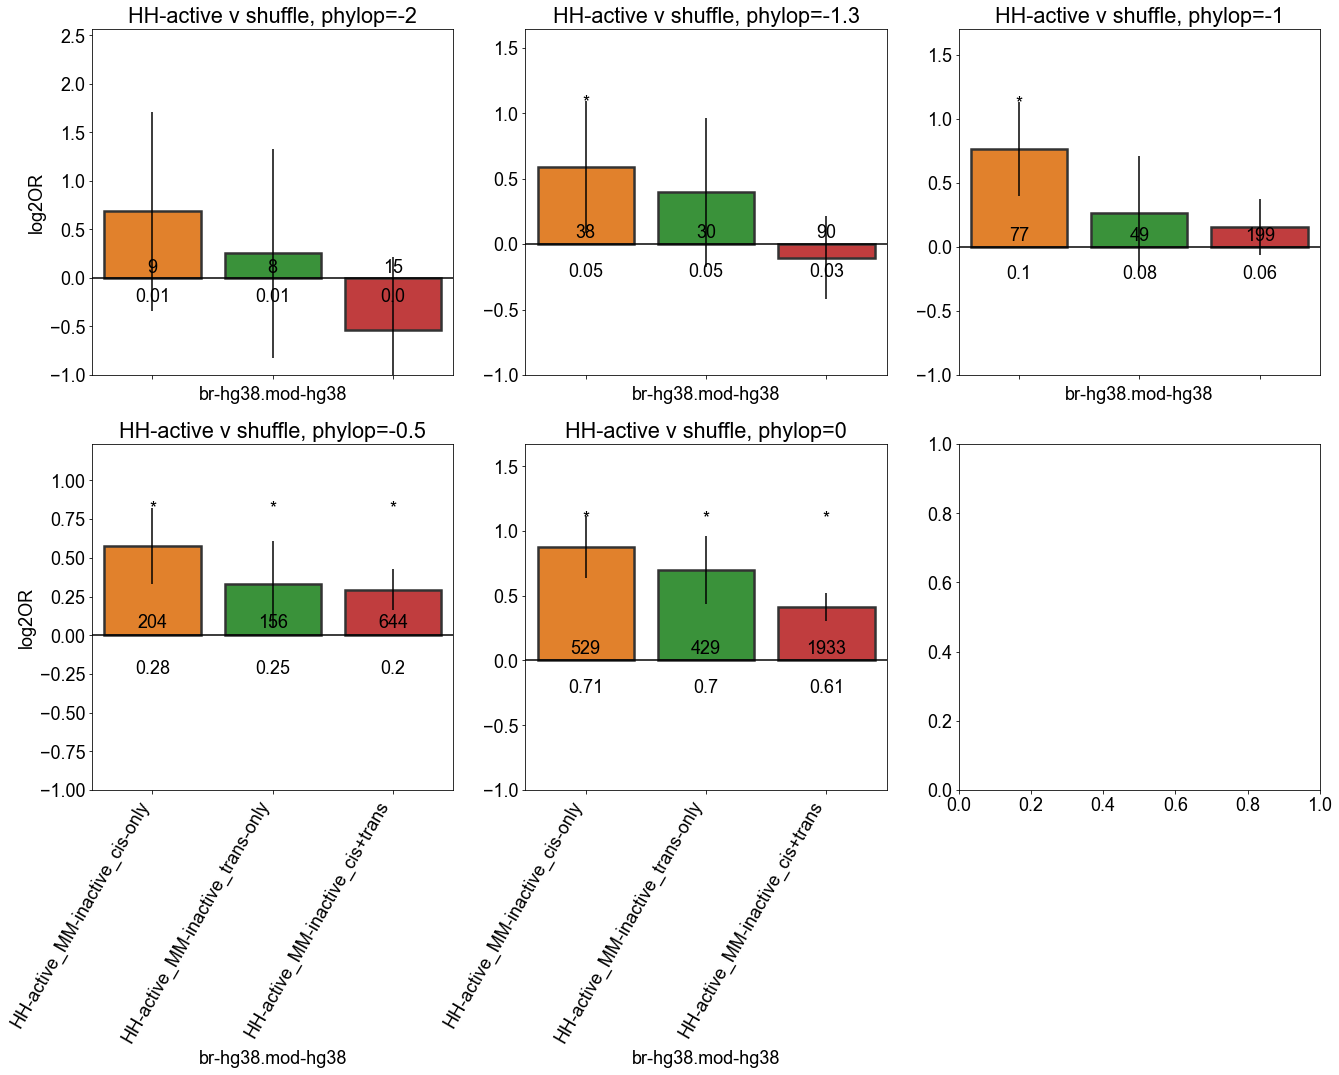

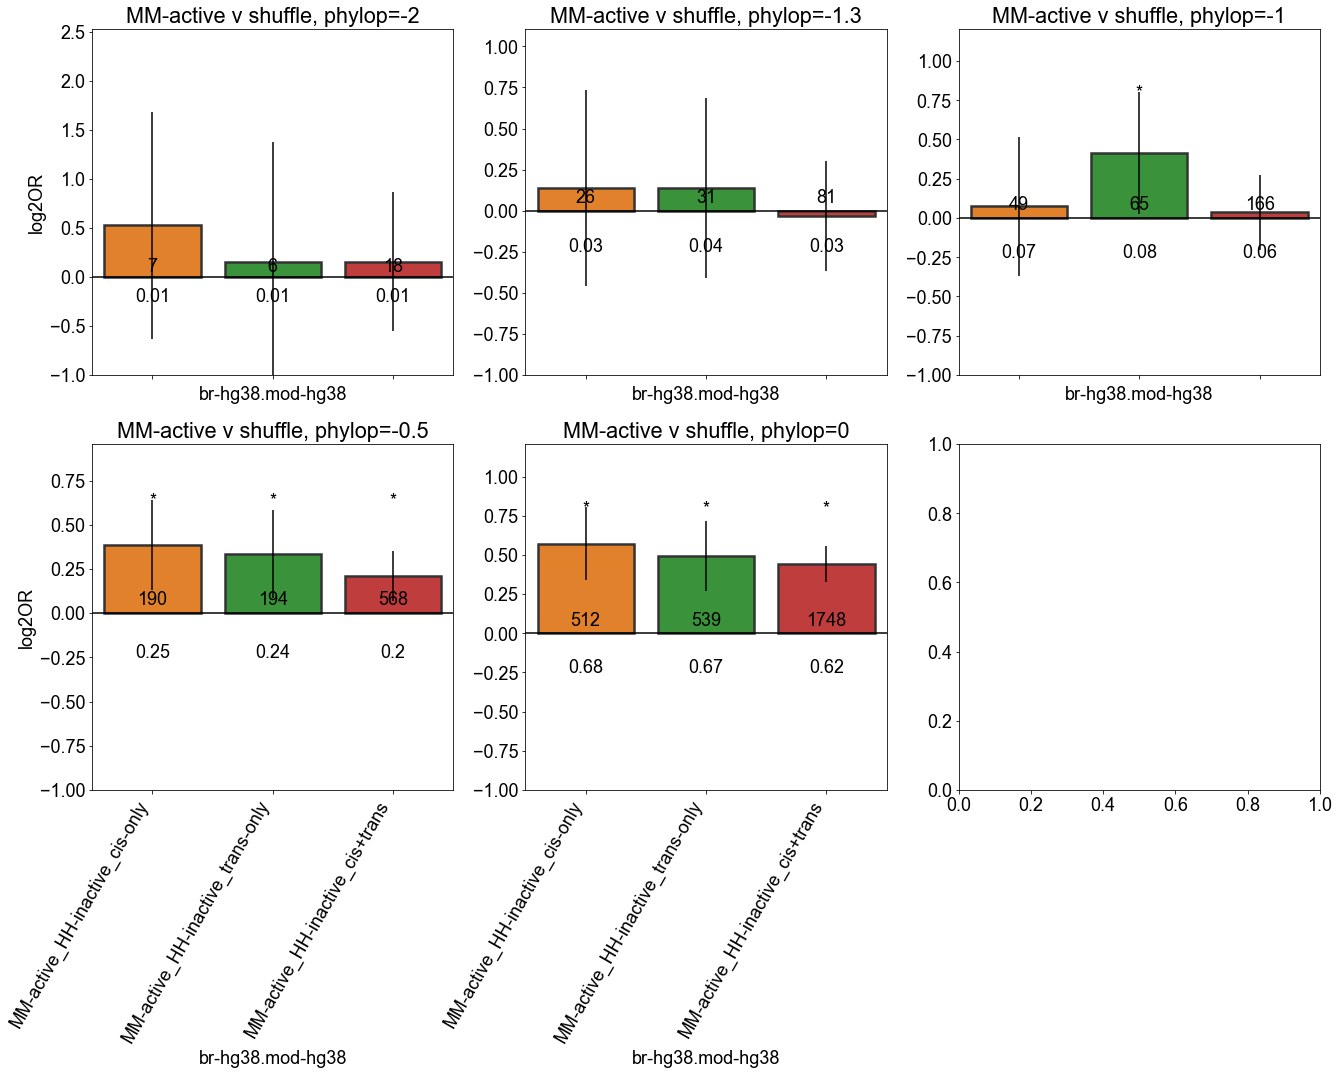

In [48]:
plot_results=results
bkgd = 'shuffle'
plot_or(active_comps, plot_results, bkgd, BRANCH)

## Main text figure

In [49]:
cutoff = -1

if cutoff == -1.3:
    CUTOFF_P = 0.05
    
elif cutoff==-1:
    CUTOFF_P=0.10

if MRCA_HuRh is True:
    
    NEUTRAL_MODEL= "human-rhesus common ancestor"
    name="hg38-noAPES"

else:
    
    NEUTRAL_MODEL= "human-chimpanzee common ancestor"
    name = "hg38-full"
    
CAPTION = f"All divergent elements are enriched for human acceleration\
\ncompared with 10x matched shuffle.\
\nBriefly, cis-only, trans-only, and cis+trans regions and 10x length-matched, inactive, shared accessible\
\nshuffled regions were intersected with 50bp bin {NEUTRAL_MODEL} phylop estimates between tiling along the length of accessible sequence.\
\nEach region was assigned a phylop score from the lowest (most accelerated) bin in the sequence. We used \
\nFisher's Exact Test to measure the enrichment of divergent regions with phylop score p<{CUTOFF_P} versus\
\n10x matched shuffle regions meeting the same phylop score threshold."

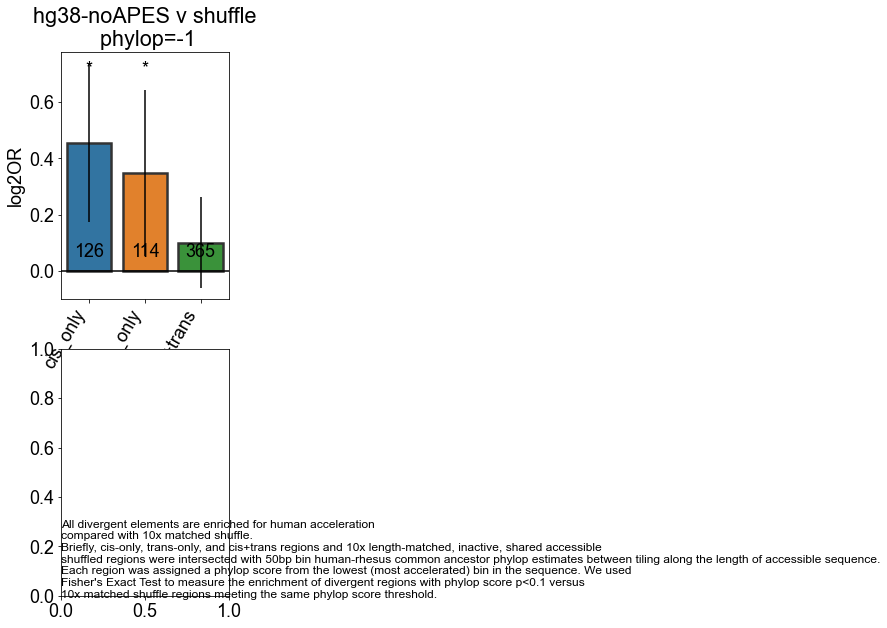

In [52]:
comps=["cis_only", "trans_only", "cis+trans"]

d = results.loc[(results["activity"].isin(comps))
           &(results["phylop_cutoff"]==cutoff)]

d=reindex_in_comp_order(d, comps)
y="OR_log2"
x="activity"
size="frac"
ci_upper, ci_lower= "ci_upper_log2", "ci_lower_log2"

fig, (ax, capax) = plt.subplots(nrows = 2, figsize =(3,10))

# get difference between y and upper/lower CI for plotting. 
l = np.array(d[y]-d[ci_lower])
u = np.array(d[ci_upper]- d[y])

yerr = [l, u]

sns.barplot(
    x=x, y=y, data=d,
    order = comps,
    
    linewidth=2.5, 
    edgecolor=".2",
    **{"yerr":yerr},
    ax=ax

)

ax.set(xlabel =BRANCH,
       ylabel = "log2OR",
       title=f"{name} v {bkgd}\n phylop={cutoff}",
       #ylim =(-1, (data[ci_upper].max()+data[ci_upper].max()*0.5))
      )

ax.axhline(0, color="k")

# add annotations
ax.set_xticklabels(ax.get_xticklabels(), rotation =60, horizontalalignment="right")

annotate_bar(ax, d["astrisks"], (d[ci_upper].max()-d[ci_upper].max()*0.05)) # asterisks
annotate_bar(ax, d["a"], 0.05)  # count of accelerated elements
annotate_bar(ax, d["frac"].round(2),-0.25)  # fraction of the activity category that is accelerated at cut-off
#annotate_bar(ax, data["OR"].round(2), (data[ci_upper].max()-data[ci_upper].max()*0.2))


capax.text(0, 0, CAPTION, wrap=True, horizontalalignment='left', fontsize=12)

# save the figure
out = os.path.join(RE, f"{BRANCH}-{name}_v_shuffle_phylop_{cutoff}_min.pdf")
plt.savefig(out,bbox_inches="tight")

In [53]:
d

,activity,a,b,c,d,OR,P,ci_lower,ci_lower_diff,ci_upper,...,ci_upper_log2,comparison,bkgd,phylop_cutoff,-log10p,frac,astrisks,reject_null,FDR_P,asterisks
0,cis_only,126,1364,858,12738,1.371419,0.001951,1.128284,0.281540,1.666948,...,0.737209,cis_only-region_v_shuf_phylop-1,matched_shufffle,-1.0,2.311739,0.08,*,True,0.004878,*
1,trans_only,114,1301,805,11701,1.273663,0.023696,1.038284,0.294783,1.562404,...,0.643767,trans_only-region_v_shuf_phylop-1,matched_shufffle,-1.0,1.324293,0.08,*,True,0.047392,*
2,cis+trans,365,5637,3034,50240,1.072208,0.218867,0.958581,0.161612,1.199303,...,0.262196,cis+trans-region_v_shuf_phylop-1,matched_shufffle,-1.0,0.517152,0.06,None,False,0.303982,None


# heatmap of all enrichments and p-values 

In [54]:
table = results.pivot(index = "activity", columns = "phylop_cutoff", values = "OR_log2")
ptable = results.pivot(index = "activity", columns = "phylop_cutoff", values = "FDR_P")
atable = results.pivot(index = "activity", columns = "phylop_cutoff", values = "asterisks")
ftable = results.pivot(index = "activity", columns = "phylop_cutoff", values = "frac")

reindex = [
    'conserved_active.regions',
    'cis_only',
    'trans_only',
    'cis+trans',


    'HH-active_MM-inactive_cis-only',
    'HH-active_MM-inactive_trans-only',
    'HH-active_MM-inactive_cis+trans',

    'MM-active_HH-inactive_cis-only',
    'MM-active_HH-inactive_trans-only',
    'MM-active_HH-inactive_cis+trans',
    ]
table=table.loc[reindex]
ptable=ptable.loc[reindex]
atable=atable.loc[reindex]
ftable=ftable.loc[reindex]
#ptable=ptable.round(2)

In [55]:
table

phylop_cutoff,-2.0,-1.3,-1.0,-0.5,0.0
activity,,,,,
conserved_active.regions,0.492903,0.473394,0.506501,0.660641,0.964150
cis_only,0.610188,0.387485,0.455669,0.481422,0.722515
trans_only,0.225246,0.261463,0.348984,0.334191,0.580355
cis+trans,-0.203495,-0.071859,0.100584,0.253831,0.427588
HH-active_MM-inactive_cis-only,0.685777,0.591286,0.766143,0.575932,0.874249
HH-active_MM-inactive_trans-only,0.252876,0.396208,0.260674,0.327943,0.699897
HH-active_MM-inactive_cis+trans,-0.539442,-0.105381,0.155292,0.292795,0.413269
MM-active_HH-inactive_cis-only,0.526614,0.139085,0.074352,0.384918,0.571994
MM-active_HH-inactive_trans-only,0.148552,0.137763,0.412613,0.334335,0.491836


In [56]:
ptable

phylop_cutoff,-2.0,-1.3,-1.0,-0.5,0.0
activity,,,,,
conserved_active.regions,0.110905,0.001151,0.000004,9.436416e-20,1.530560e-33
cis_only,0.188935,0.090686,0.004878,8.512233e-07,5.215072e-17
trans_only,0.668177,0.293612,0.047392,1.344051e-03,6.441826e-11
cis+trans,0.627513,0.684312,0.303982,1.589706e-06,2.610668e-25
HH-active_MM-inactive_cis-only,0.288739,0.056030,0.000319,2.835744e-05,1.514251e-12
HH-active_MM-inactive_trans-only,0.754110,0.286343,0.367693,4.739222e-02,6.240756e-07
HH-active_MM-inactive_cis+trans,0.293612,0.668177,0.275528,6.374013e-05,3.689607e-13
MM-active_HH-inactive_cis-only,0.456036,0.750476,0.797088,8.056560e-03,4.662112e-06
MM-active_HH-inactive_trans-only,0.836594,0.715818,0.074694,1.907723e-02,4.209291e-05


In [57]:
atable = atable.fillna(" ")
ftable

phylop_cutoff,-2.0,-1.3,-1.0,-0.5,0.0
activity,,,,,
conserved_active.regions,0.02,0.07,0.13,0.37,0.80
cis_only,0.01,0.04,0.08,0.26,0.70
trans_only,0.01,0.04,0.08,0.25,0.68
cis+trans,0.01,0.03,0.06,0.20,0.61
HH-active_MM-inactive_cis-only,0.01,0.05,0.10,0.28,0.71
HH-active_MM-inactive_trans-only,0.01,0.05,0.08,0.25,0.70
HH-active_MM-inactive_cis+trans,0.00,0.03,0.06,0.20,0.61
MM-active_HH-inactive_cis-only,0.01,0.03,0.07,0.25,0.68
MM-active_HH-inactive_trans-only,0.01,0.04,0.08,0.24,0.67


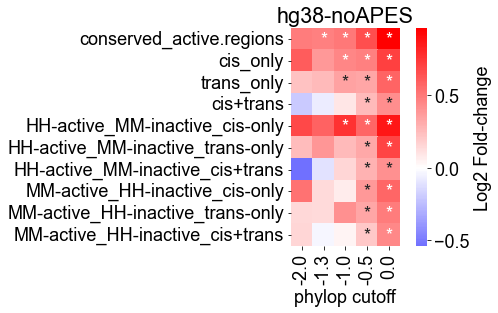

In [58]:
sns.heatmap(table, annot=atable, fmt="", cmap="bwr",square =True, center=0,
    cbar_kws={'label': 'Log2 Fold-change'})
plt.xlabel("phylop cutoff")
plt.ylabel("")
plt.title(name)
out = os.path.join(RE, f"{BRANCH}-shuf_phylop_min-heatmap.pdf")
plt.savefig(out, bbox_inches="tight")